In [2]:
import algos
import bandit
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
import utils
import pickle

plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100

N_TASKS = 1000
N_ARMS = 5
OPT_SIZE = 2
HORIZON = 250
N_EXPERT = None #None: All possible combinations
N_EXPS = 10 #No. of repeat experiments
GAP_THRESHOLD = min(1,np.sqrt(N_ARMS*np.log(N_TASKS)/HORIZON)*1.05)
kwargs = {'task_cache_step': 10,
          'gap_constrain':GAP_THRESHOLD
          'plot_var': True,
         }
assert kwargs['gap_constrain']>=GAP_THRESHOLD, f"kwargs['gap_constrain'] ({kwargs['gap_constrain']}) must be larger than GAP_THRESHOLD ({GAP_THRESHOLD})"
if N_EXPERT is not None:
    print(f'N_EXPERT = {N_EXPERT}')
    max_n_expert = len(list(combinations(np.arange(N_ARMS),OPT_SIZE)))
    assert N_EXPERT<=max_n_expert, f"The number of expert ({N_EXPERT}) must be smaller than the maximum combination ({max_n_expert})"
assert N_ARMS<=HORIZON, f"The number of arm ({N_ARMS}) must be smaller than the horizon ({HORIZON})"

In [3]:
GAP_THRESHOLD

0.3716922188849838

## Regret vs Number of tasks

  0%|          | 0/10 [00:00<?, ?it/s]

Optimal expert index = 3
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1


 10%|█         | 1/10 [00:48<07:16, 48.48s/it]

PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1


 20%|██        | 2/10 [01:37<06:28, 48.55s/it]

PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1


 30%|███       | 3/10 [02:25<05:40, 48.58s/it]

PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1


 40%|████      | 4/10 [03:14<04:51, 48.63s/it]

PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1


 50%|█████     | 5/10 [04:04<04:04, 48.95s/it]

PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1


 60%|██████    | 6/10 [04:53<03:16, 49.07s/it]

PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1


 70%|███████   | 7/10 [05:42<02:26, 48.88s/it]

PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1


 80%|████████  | 8/10 [06:30<01:37, 48.65s/it]

PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1


 90%|█████████ | 9/10 [07:18<00:48, 48.59s/it]

PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1


100%|██████████| 10/10 [08:07<00:00, 48.61s/it]


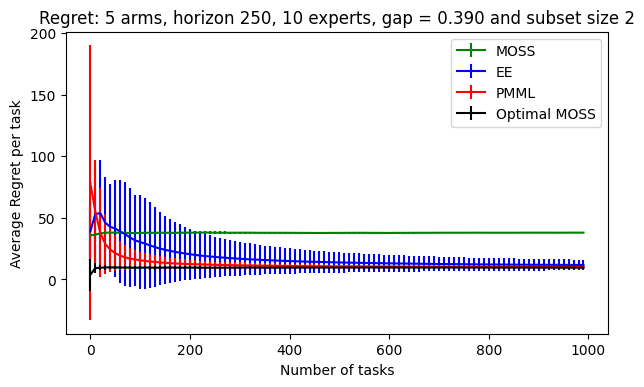

In [3]:
(X, regret_dict, title, xlabel, ylabel) = utils.task_exp(N_EXPS, N_TASKS, N_ARMS, HORIZON, OPT_SIZE, N_EXPERT, **kwargs)
pickle.dump(regret_dict, open("results/tasks.p", "wb"))
regret_dict = pickle.load(open("results/tasks.p", "rb"))
pass

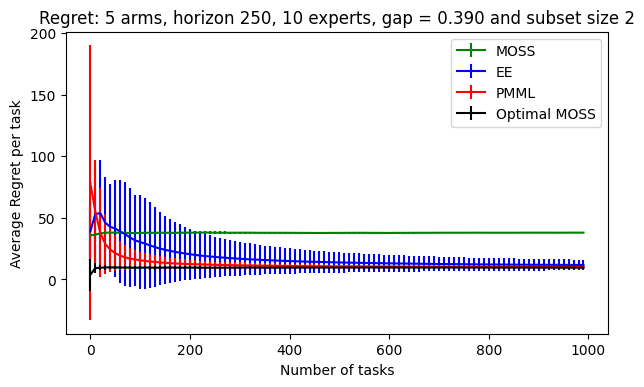

In [6]:
# # Plot from loaded cache file
# X = np.arange(N_TASKS)
# gap = kwargs['gap_constrain']
# regret_dict = pickle.load(open("results/tasks_cache.p", "rb"))
# n_experts=10
# title = f'Regret: {N_ARMS} arms, horizon {HORIZON}, {n_experts} experts, gap = {gap:.3f} and subset size {OPT_SIZE}'
# xlabel, ylabel = 'Number of tasks', 'Average Regret per task'
# indices = np.arange(0, X.shape[0], kwargs['task_cache_step']).astype(int)
# utils.plot(X[indices], regret_dict, title, xlabel, ylabel, kwargs['plot_var'])

## Regret vs Horizon

  0%|          | 0/10 [00:00<?, ?it/s]

gap = 0.8420259399671777
Optimal expert index = 7
PMML_EWA: self.delta_n = 0.07789637026316759, self.learning_rate=1
gap = 0.5954022520857681
Optimal expert index = 9
PMML_EWA: self.delta_n = 0.0926349177498453, self.learning_rate=1
gap = 0.4861439031046977
Optimal expert index = 9
PMML_EWA: self.delta_n = 0.10251738860668018, self.learning_rate=1
gap = 0.42101296998358884
Optimal expert index = 2
PMML_EWA: self.delta_n = 0.11016210328580787, self.learning_rate=1
gap = 0.37656544811695325
Optimal expert index = 5
PMML_EWA: self.delta_n = 0.11648224233458458, self.learning_rate=1
gap = 0.34375565051782764
Optimal expert index = 8
PMML_EWA: self.delta_n = 0.12191440794256297, self.learning_rate=1


 10%|█         | 1/10 [04:17<38:40, 257.83s/it]

gap = 0.8420259399671777
Optimal expert index = 5
PMML_EWA: self.delta_n = 0.07789637026316759, self.learning_rate=1
gap = 0.5954022520857681
Optimal expert index = 7
PMML_EWA: self.delta_n = 0.0926349177498453, self.learning_rate=1
gap = 0.4861439031046977
Optimal expert index = 5
PMML_EWA: self.delta_n = 0.10251738860668018, self.learning_rate=1
gap = 0.42101296998358884
Optimal expert index = 9
PMML_EWA: self.delta_n = 0.11016210328580787, self.learning_rate=1
gap = 0.37656544811695325
Optimal expert index = 9
PMML_EWA: self.delta_n = 0.11648224233458458, self.learning_rate=1
gap = 0.34375565051782764
Optimal expert index = 4
PMML_EWA: self.delta_n = 0.12191440794256297, self.learning_rate=1


 20%|██        | 2/10 [08:31<34:12, 256.61s/it]

gap = 0.8420259399671777
Optimal expert index = 5
PMML_EWA: self.delta_n = 0.07789637026316759, self.learning_rate=1
gap = 0.5954022520857681
Optimal expert index = 4
PMML_EWA: self.delta_n = 0.0926349177498453, self.learning_rate=1
gap = 0.4861439031046977
Optimal expert index = 3
PMML_EWA: self.delta_n = 0.10251738860668018, self.learning_rate=1
gap = 0.42101296998358884
Optimal expert index = 8
PMML_EWA: self.delta_n = 0.11016210328580787, self.learning_rate=1
gap = 0.37656544811695325
Optimal expert index = 5
PMML_EWA: self.delta_n = 0.11648224233458458, self.learning_rate=1
gap = 0.34375565051782764
Optimal expert index = 1
PMML_EWA: self.delta_n = 0.12191440794256297, self.learning_rate=1


 30%|███       | 3/10 [12:47<29:55, 256.52s/it]

gap = 0.8420259399671777
Optimal expert index = 9
PMML_EWA: self.delta_n = 0.07789637026316759, self.learning_rate=1
gap = 0.5954022520857681
Optimal expert index = 9
PMML_EWA: self.delta_n = 0.0926349177498453, self.learning_rate=1
gap = 0.4861439031046977
Optimal expert index = 9
PMML_EWA: self.delta_n = 0.10251738860668018, self.learning_rate=1
gap = 0.42101296998358884
Optimal expert index = 6
PMML_EWA: self.delta_n = 0.11016210328580787, self.learning_rate=1
gap = 0.37656544811695325
Optimal expert index = 6
PMML_EWA: self.delta_n = 0.11648224233458458, self.learning_rate=1
gap = 0.34375565051782764
Optimal expert index = 5
PMML_EWA: self.delta_n = 0.12191440794256297, self.learning_rate=1


 40%|████      | 4/10 [17:00<25:31, 255.22s/it]

gap = 0.8420259399671777
Optimal expert index = 1
PMML_EWA: self.delta_n = 0.07789637026316759, self.learning_rate=1
gap = 0.5954022520857681
Optimal expert index = 7
PMML_EWA: self.delta_n = 0.0926349177498453, self.learning_rate=1
gap = 0.4861439031046977
Optimal expert index = 8
PMML_EWA: self.delta_n = 0.10251738860668018, self.learning_rate=1
gap = 0.42101296998358884
Optimal expert index = 9
PMML_EWA: self.delta_n = 0.11016210328580787, self.learning_rate=1
gap = 0.37656544811695325
Optimal expert index = 5
PMML_EWA: self.delta_n = 0.11648224233458458, self.learning_rate=1
gap = 0.34375565051782764
Optimal expert index = 4
PMML_EWA: self.delta_n = 0.12191440794256297, self.learning_rate=1


 50%|█████     | 5/10 [21:14<21:15, 255.03s/it]

gap = 0.8420259399671777
Optimal expert index = 9
PMML_EWA: self.delta_n = 0.07789637026316759, self.learning_rate=1
gap = 0.5954022520857681
Optimal expert index = 4
PMML_EWA: self.delta_n = 0.0926349177498453, self.learning_rate=1
gap = 0.4861439031046977
Optimal expert index = 5
PMML_EWA: self.delta_n = 0.10251738860668018, self.learning_rate=1
gap = 0.42101296998358884
Optimal expert index = 0
PMML_EWA: self.delta_n = 0.11016210328580787, self.learning_rate=1
gap = 0.37656544811695325
Optimal expert index = 8
PMML_EWA: self.delta_n = 0.11648224233458458, self.learning_rate=1
gap = 0.34375565051782764
Optimal expert index = 8
PMML_EWA: self.delta_n = 0.12191440794256297, self.learning_rate=1


 60%|██████    | 6/10 [25:30<17:01, 255.41s/it]

gap = 0.8420259399671777
Optimal expert index = 7
PMML_EWA: self.delta_n = 0.07789637026316759, self.learning_rate=1
gap = 0.5954022520857681
Optimal expert index = 7
PMML_EWA: self.delta_n = 0.0926349177498453, self.learning_rate=1
gap = 0.4861439031046977
Optimal expert index = 8
PMML_EWA: self.delta_n = 0.10251738860668018, self.learning_rate=1
gap = 0.42101296998358884
Optimal expert index = 3
PMML_EWA: self.delta_n = 0.11016210328580787, self.learning_rate=1
gap = 0.37656544811695325
Optimal expert index = 0
PMML_EWA: self.delta_n = 0.11648224233458458, self.learning_rate=1
gap = 0.34375565051782764
Optimal expert index = 2
PMML_EWA: self.delta_n = 0.12191440794256297, self.learning_rate=1


 70%|███████   | 7/10 [29:45<12:45, 255.18s/it]

gap = 0.8420259399671777
Optimal expert index = 1
PMML_EWA: self.delta_n = 0.07789637026316759, self.learning_rate=1
gap = 0.5954022520857681
Optimal expert index = 4
PMML_EWA: self.delta_n = 0.0926349177498453, self.learning_rate=1
gap = 0.4861439031046977
Optimal expert index = 8
PMML_EWA: self.delta_n = 0.10251738860668018, self.learning_rate=1
gap = 0.42101296998358884
Optimal expert index = 5
PMML_EWA: self.delta_n = 0.11016210328580787, self.learning_rate=1
gap = 0.37656544811695325
Optimal expert index = 9
PMML_EWA: self.delta_n = 0.11648224233458458, self.learning_rate=1
gap = 0.34375565051782764
Optimal expert index = 9
PMML_EWA: self.delta_n = 0.12191440794256297, self.learning_rate=1


 80%|████████  | 8/10 [33:58<08:28, 254.37s/it]

gap = 0.8420259399671777
Optimal expert index = 2
PMML_EWA: self.delta_n = 0.07789637026316759, self.learning_rate=1
gap = 0.5954022520857681
Optimal expert index = 3
PMML_EWA: self.delta_n = 0.0926349177498453, self.learning_rate=1
gap = 0.4861439031046977
Optimal expert index = 5
PMML_EWA: self.delta_n = 0.10251738860668018, self.learning_rate=1
gap = 0.42101296998358884
Optimal expert index = 6
PMML_EWA: self.delta_n = 0.11016210328580787, self.learning_rate=1
gap = 0.37656544811695325
Optimal expert index = 4
PMML_EWA: self.delta_n = 0.11648224233458458, self.learning_rate=1
gap = 0.34375565051782764
Optimal expert index = 6
PMML_EWA: self.delta_n = 0.12191440794256297, self.learning_rate=1


 90%|█████████ | 9/10 [38:11<04:13, 253.96s/it]

gap = 0.8420259399671777
Optimal expert index = 2
PMML_EWA: self.delta_n = 0.07789637026316759, self.learning_rate=1
gap = 0.5954022520857681
Optimal expert index = 6
PMML_EWA: self.delta_n = 0.0926349177498453, self.learning_rate=1
gap = 0.4861439031046977
Optimal expert index = 6
PMML_EWA: self.delta_n = 0.10251738860668018, self.learning_rate=1
gap = 0.42101296998358884
Optimal expert index = 8
PMML_EWA: self.delta_n = 0.11016210328580787, self.learning_rate=1
gap = 0.37656544811695325
Optimal expert index = 1
PMML_EWA: self.delta_n = 0.11648224233458458, self.learning_rate=1
gap = 0.34375565051782764
Optimal expert index = 4
PMML_EWA: self.delta_n = 0.12191440794256297, self.learning_rate=1


100%|██████████| 10/10 [42:28<00:00, 255.14s/it]


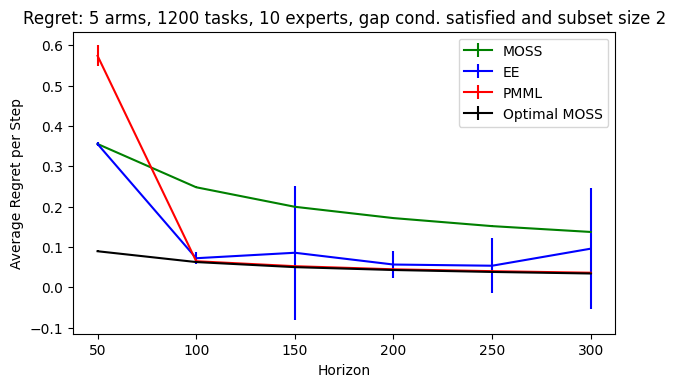

In [6]:
horizon_list = np.arange(50, 310, 50)
n_tasks = np.ceil(N_TASKS*max(horizon_list)/HORIZON).astype(int)
(X_h, regret_dict_h, title, xlabel, ylabel) = \
utils.horizon_exp(N_EXPS, n_tasks, N_ARMS, OPT_SIZE, N_EXPERT, 
                  horizon_list = horizon_list, **kwargs)
pickle.dump(regret_dict_h, open("results/horizon.p", "wb"))
regret_dict_h = pickle.load(open("results/horizon.p", "rb"))
pass

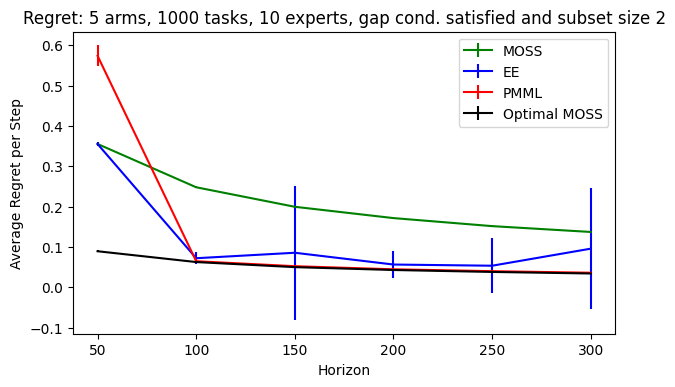

In [7]:
# # Plot from loaded cache file
# X_h = np.arange(50, 310, 50)
# n_experts=10
# regret_dict_h = pickle.load(open("results/horizon.p", "rb"))
# title = f'Regret: {N_ARMS} arms, {N_TASKS} tasks, {n_experts} experts, gap cond. satisfied and subset size {OPT_SIZE}'
# xlabel, ylabel = 'Horizon', 'Average Regret per Step'
# utils.plot(X_h, regret_dict_h, title, xlabel, ylabel, kwargs['plot_var'])

## Regret vs # of arm

  0%|          | 0/10 [00:00<?, ?it/s]

Optimal expert index = 2
PMML_EWA: self.delta_n = 0.10014445669930187, self.learning_rate=1
Optimal expert index = 5
PMML_EWA: self.delta_n = 0.1190172355368649, self.learning_rate=1
Optimal expert index = 5
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 14
PMML_EWA: self.delta_n = 0.1322134217188413, self.learning_rate=1
Optimal expert index = 16
PMML_EWA: self.delta_n = 0.13488699565427953, self.learning_rate=1


 10%|█         | 1/10 [04:15<38:16, 255.11s/it]

Optimal expert index = 0
PMML_EWA: self.delta_n = 0.10014445669930187, self.learning_rate=1
Optimal expert index = 1
PMML_EWA: self.delta_n = 0.1190172355368649, self.learning_rate=1
Optimal expert index = 4
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 10
PMML_EWA: self.delta_n = 0.1322134217188413, self.learning_rate=1
Optimal expert index = 12
PMML_EWA: self.delta_n = 0.13488699565427953, self.learning_rate=1


 20%|██        | 2/10 [08:29<33:58, 254.86s/it]

Optimal expert index = 1
PMML_EWA: self.delta_n = 0.10014445669930187, self.learning_rate=1
Optimal expert index = 3
PMML_EWA: self.delta_n = 0.1190172355368649, self.learning_rate=1
Optimal expert index = 3
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 3
PMML_EWA: self.delta_n = 0.1322134217188413, self.learning_rate=1
Optimal expert index = 11
PMML_EWA: self.delta_n = 0.13488699565427953, self.learning_rate=1


 30%|███       | 3/10 [12:39<29:33, 253.33s/it]

Optimal expert index = 2
PMML_EWA: self.delta_n = 0.10014445669930187, self.learning_rate=1
Optimal expert index = 4
PMML_EWA: self.delta_n = 0.1190172355368649, self.learning_rate=1
Optimal expert index = 2
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 8
PMML_EWA: self.delta_n = 0.1322134217188413, self.learning_rate=1
Optimal expert index = 1
PMML_EWA: self.delta_n = 0.13488699565427953, self.learning_rate=1


 40%|████      | 4/10 [16:51<25:18, 253.08s/it]

Optimal expert index = 1
PMML_EWA: self.delta_n = 0.10014445669930187, self.learning_rate=1
Optimal expert index = 5
PMML_EWA: self.delta_n = 0.1190172355368649, self.learning_rate=1
Optimal expert index = 1
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 14
PMML_EWA: self.delta_n = 0.1322134217188413, self.learning_rate=1
Optimal expert index = 5
PMML_EWA: self.delta_n = 0.13488699565427953, self.learning_rate=1


 50%|█████     | 5/10 [21:06<21:08, 253.69s/it]

Optimal expert index = 1
PMML_EWA: self.delta_n = 0.10014445669930187, self.learning_rate=1
Optimal expert index = 3
PMML_EWA: self.delta_n = 0.1190172355368649, self.learning_rate=1
Optimal expert index = 5
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 1
PMML_EWA: self.delta_n = 0.1322134217188413, self.learning_rate=1
Optimal expert index = 9
PMML_EWA: self.delta_n = 0.13488699565427953, self.learning_rate=1


 60%|██████    | 6/10 [25:20<16:54, 253.67s/it]

Optimal expert index = 0
PMML_EWA: self.delta_n = 0.10014445669930187, self.learning_rate=1
Optimal expert index = 2
PMML_EWA: self.delta_n = 0.1190172355368649, self.learning_rate=1
Optimal expert index = 2
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 14
PMML_EWA: self.delta_n = 0.1322134217188413, self.learning_rate=1
Optimal expert index = 0
PMML_EWA: self.delta_n = 0.13488699565427953, self.learning_rate=1


 70%|███████   | 7/10 [29:30<12:37, 252.61s/it]

Optimal expert index = 1
PMML_EWA: self.delta_n = 0.10014445669930187, self.learning_rate=1
Optimal expert index = 3
PMML_EWA: self.delta_n = 0.1190172355368649, self.learning_rate=1
Optimal expert index = 7
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 6
PMML_EWA: self.delta_n = 0.1322134217188413, self.learning_rate=1
Optimal expert index = 6
PMML_EWA: self.delta_n = 0.13488699565427953, self.learning_rate=1


 80%|████████  | 8/10 [33:43<08:25, 252.60s/it]

Optimal expert index = 2
PMML_EWA: self.delta_n = 0.10014445669930187, self.learning_rate=1
Optimal expert index = 0
PMML_EWA: self.delta_n = 0.1190172355368649, self.learning_rate=1
Optimal expert index = 9
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 13
PMML_EWA: self.delta_n = 0.1322134217188413, self.learning_rate=1
Optimal expert index = 16
PMML_EWA: self.delta_n = 0.13488699565427953, self.learning_rate=1


 90%|█████████ | 9/10 [37:53<04:11, 251.81s/it]

Optimal expert index = 2
PMML_EWA: self.delta_n = 0.10014445669930187, self.learning_rate=1
Optimal expert index = 0
PMML_EWA: self.delta_n = 0.1190172355368649, self.learning_rate=1
Optimal expert index = 2
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 9
PMML_EWA: self.delta_n = 0.1322134217188413, self.learning_rate=1
Optimal expert index = 3
PMML_EWA: self.delta_n = 0.13488699565427953, self.learning_rate=1


100%|██████████| 10/10 [42:04<00:00, 251.74s/it]


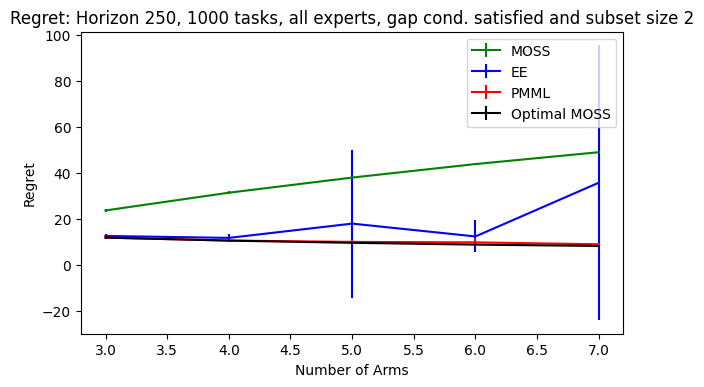

In [8]:
n_arms_list = np.arange(3,8,1)
(X_b, regret_dict_b, title, xlabel, ylabel) = \
utils.arms_exp(N_EXPS, N_TASKS, HORIZON, OPT_SIZE, N_EXPERT, n_arms_list, **kwargs)
pickle.dump(regret_dict_b, open("results/arms.p", "wb"))
regret_dict_h = pickle.load(open("results/arms.p", "rb"))
pass

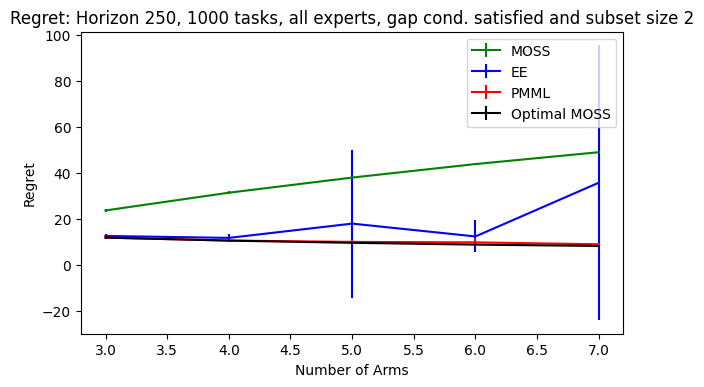

In [9]:
# # Plot from loaded cache file
# title = f'Regret: Horizon {HORIZON}, {N_TASKS} tasks, all experts, gap cond. satisfied and subset size {OPT_SIZE}'
# xlabel, ylabel = 'Number of Arms', 'Regret'
# X_b = np.arange(3,8,1)
# regret_dict_b = pickle.load(open("results/arms.p", "rb"))
# utils.plot(X_b, regret_dict_b, title, xlabel, ylabel, kwargs['plot_var'])

## Regret vs subset size

  0%|          | 0/10 [00:00<?, ?it/s]

Optimal expert index = 4
PMML_EWA: self.delta_n = 0.10667916674688048, self.learning_rate=1
Optimal expert index = 6
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 8
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 2
PMML_EWA: self.delta_n = 0.10667916674688048, self.learning_rate=1
Optimal expert index = 0
PMML_EWA: self.delta_n = 0.0, self.learning_rate=1


 10%|█         | 1/10 [04:04<36:39, 244.34s/it]

Optimal expert index = 0
PMML_EWA: self.delta_n = 0.10667916674688048, self.learning_rate=1
Optimal expert index = 1
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 2
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 2
PMML_EWA: self.delta_n = 0.10667916674688048, self.learning_rate=1
Optimal expert index = 0
PMML_EWA: self.delta_n = 0.0, self.learning_rate=1


 20%|██        | 2/10 [08:04<32:23, 242.95s/it]

Optimal expert index = 0
PMML_EWA: self.delta_n = 0.10667916674688048, self.learning_rate=1
Optimal expert index = 6
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 1
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 0
PMML_EWA: self.delta_n = 0.10667916674688048, self.learning_rate=1
Optimal expert index = 0
PMML_EWA: self.delta_n = 0.0, self.learning_rate=1


 30%|███       | 3/10 [12:10<28:28, 244.04s/it]

Optimal expert index = 0
PMML_EWA: self.delta_n = 0.10667916674688048, self.learning_rate=1
Optimal expert index = 5
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 7
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 4
PMML_EWA: self.delta_n = 0.10667916674688048, self.learning_rate=1
Optimal expert index = 0
PMML_EWA: self.delta_n = 0.0, self.learning_rate=1


 40%|████      | 4/10 [16:13<24:22, 243.83s/it]

Optimal expert index = 2
PMML_EWA: self.delta_n = 0.10667916674688048, self.learning_rate=1
Optimal expert index = 5
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 3
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 4
PMML_EWA: self.delta_n = 0.10667916674688048, self.learning_rate=1
Optimal expert index = 0
PMML_EWA: self.delta_n = 0.0, self.learning_rate=1


 50%|█████     | 5/10 [20:17<20:18, 243.67s/it]

Optimal expert index = 2
PMML_EWA: self.delta_n = 0.10667916674688048, self.learning_rate=1
Optimal expert index = 6
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 1
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 1
PMML_EWA: self.delta_n = 0.10667916674688048, self.learning_rate=1
Optimal expert index = 0
PMML_EWA: self.delta_n = 0.0, self.learning_rate=1


 60%|██████    | 6/10 [24:19<16:12, 243.18s/it]

Optimal expert index = 2
PMML_EWA: self.delta_n = 0.10667916674688048, self.learning_rate=1
Optimal expert index = 8
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 2
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 0
PMML_EWA: self.delta_n = 0.10667916674688048, self.learning_rate=1
Optimal expert index = 0
PMML_EWA: self.delta_n = 0.0, self.learning_rate=1


 70%|███████   | 7/10 [28:21<12:08, 242.95s/it]

Optimal expert index = 3
PMML_EWA: self.delta_n = 0.10667916674688048, self.learning_rate=1
Optimal expert index = 9
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 9
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 4
PMML_EWA: self.delta_n = 0.10667916674688048, self.learning_rate=1
Optimal expert index = 0
PMML_EWA: self.delta_n = 0.0, self.learning_rate=1


 80%|████████  | 8/10 [32:21<08:04, 242.09s/it]

Optimal expert index = 0
PMML_EWA: self.delta_n = 0.10667916674688048, self.learning_rate=1
Optimal expert index = 2
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 0
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 3
PMML_EWA: self.delta_n = 0.10667916674688048, self.learning_rate=1
Optimal expert index = 0
PMML_EWA: self.delta_n = 0.0, self.learning_rate=1


 90%|█████████ | 9/10 [36:28<04:03, 243.39s/it]

Optimal expert index = 4
PMML_EWA: self.delta_n = 0.10667916674688048, self.learning_rate=1
Optimal expert index = 6
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 1
PMML_EWA: self.delta_n = 0.1275999033508704, self.learning_rate=1
Optimal expert index = 2
PMML_EWA: self.delta_n = 0.10667916674688048, self.learning_rate=1
Optimal expert index = 0
PMML_EWA: self.delta_n = 0.0, self.learning_rate=1


100%|██████████| 10/10 [40:31<00:00, 243.32s/it]


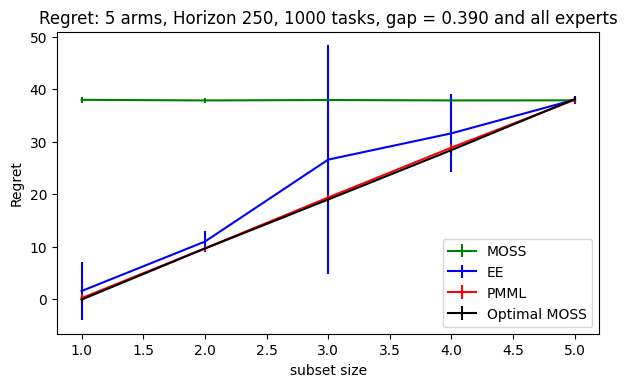

In [10]:
(X_e, regret_dict_e, title, xlabel, ylabel) = utils.subset_exp(N_EXPS, 
                                  N_TASKS, N_ARMS, HORIZON, N_EXPERT, 
                                  opt_size_list = np.arange(1,N_ARMS+1,1), **kwargs)
pickle.dump(regret_dict_e, open("results/subset.p", "wb"))
regret_dict_h = pickle.load(open("results/subset.p", "rb"))
pass

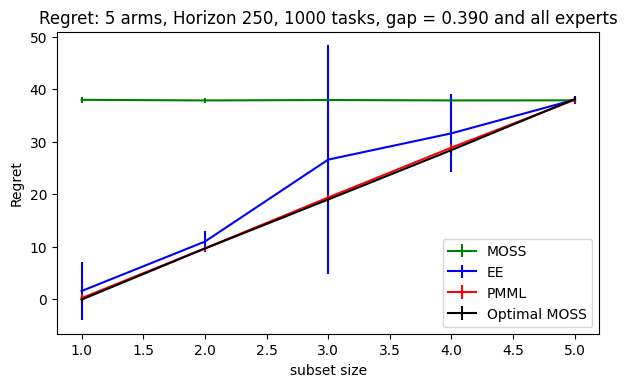

In [11]:
# # Plot from loaded cache file
# title=f'Regret: {N_ARMS} arms, Horizon {HORIZON}, {N_TASKS} tasks, gap = {gap:.3f} and all experts'
# xlabel, ylabel = 'subset size', 'Regret'
# X_e = np.arange(1,N_ARMS+1,1)
# regret_dict_e = pickle.load(open("results/subset.p", "rb"))
# utils.plot(X_e, regret_dict_e, title, xlabel, ylabel, kwargs['plot_var'])